cluster dei rifugi: 
- caratteristiche territoriali (es. altitudine, gruppi rocciosi/idrici, ..) 
- vicinanza (distanza) tra rifugi
- cluster ranking rifugi → per individuare gruppi di performance e vedere se e come cambiano (quali rifugi cambiano classi)

In [14]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
from rasterio.sample import sample_gen
from rasterio.plot import show
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.simplefilter("ignore")


# Territorial Clustering
Cluster based on topographic characteristics: 
- altitude, slope, aspect
- connection to trail network, roads, cableways
- water potential ?
- corpi idrici sotterranei (gruppo geologico) ?

In [15]:
# Load DEM raster
dem_path = "../data/terrain/tinitaly_dem50m.tif"
dem = rasterio.open(dem_path)

# Load slope raster
slope_path = "../data/terrain/tinitaly_slope50m.tif"
slope_raster = rasterio.open(slope_path)

# Load huts GeoDataFrame
huts = gpd.read_file("../data/huts/huts_points.geojson")
huts.to_crs(dem.crs, inplace=True)

In [16]:
## Extract elevation & slope
hut_coords = [(geom.x, geom.y) for geom in huts.geometry]

elevation = [val[0] for val in sample_gen(dem, hut_coords)]
slope = [val[0] for val in sample_gen(slope_raster, hut_coords)]

huts['elevation'] = elevation
huts['slope'] = slope

In [17]:
# # Accessibility: already extracted in mcdm_analysis.ipynb
# huts_criteria = gpd.read_parquet('../data/alternatives_unfiltered.parquet')
# huts_criteria.to_crs(dem.crs, inplace=True)
# huts_criteria.columns

# selected_cols = ['standard_name', 'supply_aerialway', 'supply_helicopter', 'supply_road', 'lift_ids_within_500m',
#        'lift_ids_within_2300m', 'car_access', 'arrival_trails']
# huts = huts.merge(huts_criteria[selected_cols], on='standard_name', how='left')

# # Extract data for lifts and number of trails
# if 'num_trails' not in huts.columns:
#     huts['num_trails'] = None
    
# for idx, row in huts.iterrows():
#     huts.at[idx, 'lift_500m'] = row['lift_ids_within_500m'] is not None
#     huts.at[idx, 'lift_2300m'] = row['lift_ids_within_2300m'] is not None

#     if row['arrival_trails'] is not None and len(row['arrival_trails']) > 0:
#         huts.at[idx, 'num_trails'] = len(row['arrival_trails'])

# huts.drop(columns=['lift_ids_within_500m', 'lift_ids_within_2300m'], inplace=True)
# huts.head(5)

In [18]:
## Add CR_WA_01 (quantitative water source)
huts_qnt = gpd.read_parquet("../data/alternatives_qnt.parquet")
huts_qnt.to_crs(dem.crs, inplace=True)

huts = huts.merge(huts_qnt[['standard_name', 'CR_WA_01']], on='standard_name', how='left')

In [19]:
## Add hydrogeological group ('comp_idrog') for each hut
# limestone (1), magmatic (2), floodvalley (3)
hydrogeo = gpd.read_file("../data/water/corpi_sott/cis_pta2022_v.shp")
hydrogeo.to_crs(dem.crs, inplace=True)

# Spatial join: assign hydrogeological area to each hut
huts_with_hydrogeo = gpd.sjoin(huts, hydrogeo, how="left", predicate="within")

# Extract the relevant column
huts['hydrogeo_comp'] = huts_with_hydrogeo['comp_idrog']  
huts.loc[huts['hydrogeo_comp'] == 'Calcari', 'hydrogeo_comp'] = 1 #'limestone'
huts.loc[huts['hydrogeo_comp'] == 'Vulcaniti', 'hydrogeo_comp'] = 2 #'magmatic'
huts.loc[huts['hydrogeo_comp'] == 'Alluvioni vallive', 'hydrogeo_comp'] = 3 #'flood valley'
huts.head(5)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,elevation,slope,CR_WA_01,hydrogeo_comp
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,0.0,None,POINT (666584.351 5077095.370),1802.240967,6.714721,3,1
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,0.0,None,POINT (646874.183 5074717.942),2058.592041,8.659462,3,1
2,antermoia,ANTERMOIA,D,Alp,61,2496,0.0,goods,POINT (704489.000 5150499.000),2497.357910,6.731922,2,1
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,0.0,None,POINT (666672.806 5100323.693),594.101807,47.511280,4,1
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,0.0,None,POINT (637133.000 5087416.000),1615.531982,29.171103,3,1


## Feature clustering: K-means
I use k-means to cluster huts based on the features above, which regard topographic characteristics (elevation and slope) and accessibility (for supplying and visitors).

In [52]:
from sklearn.metrics import silhouette_score

# Select relevant features for clustering
features = ['elevation', 'slope', 'CR_WA_01', 'hydrogeo_comp']# 'supply_aerialway', 'supply_helicopter', 
            #'supply_road', 'car_access', 'num_trails', 'lift_500m', 'lift_2300m']
X = huts[features]

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Set up final metrics
inertia_values = [] # sum of squared distances of samples to their closest cluster center
silhouette_scores = [] # how similar each point is to its cluster compared to other clusters
cluster_stats = {}

# Apply K-Means clustering
k_values = range(2,8)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42) 
    huts[f'cluster_kmeans_k{k}'] = kmeans.fit_predict(X_scaled)
    huts[f'cluster_kmeans_k{k}'] = huts[f'cluster_kmeans_k{k}']

    inertia_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    # Group by cluster and compute stats
    cluster_stats[f"k{k}"] = huts.groupby(f'cluster_kmeans_k{k}').agg({
        'elevation': ['mean', 'std', 'min', 'max'],
        'slope': ['mean', 'std'],
        'CR_WA_01': ['mean'],
        'hydrogeo_comp': ['mean']
        # 'supply_aerialway': ['sum'],
        # 'supply_helicopter': ['sum'],
        # 'supply_road': ['sum'],
        # 'lift_500m': ['sum'],
        # 'lift_2300m': ['sum'],
        # 'car_access': ['sum'],
        # 'num_trails': ['mean', 'min', 'max']
    })


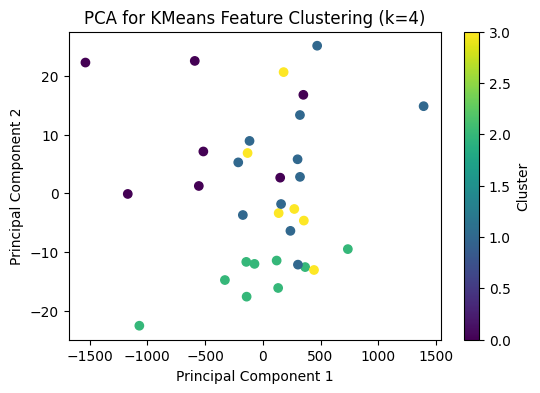

In [21]:
from sklearn.decomposition import PCA
k = 4
# Visualize clustering using PCA for dimensionality reduction (since we have many features)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(huts[features])

# Plot clusters in 2D (first two principal components)
plt.figure(figsize=(6, 4))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=huts[f'cluster_kmeans_k{k}'], cmap='viridis')
plt.title(f'PCA for KMeans Feature Clustering (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Plot clusters on map
from matplotlib.colors import ListedColormap, BoundaryNorm
from adjustText import adjust_text

def plot_kmeans_geo(huts, cluster_cols, type:str):
    cluster_colors = {
        "0": "#1f77b4",  # Blue
        "1": "#ff7f0e",  # Orange
        "2": "#2ca02c",  # Green
        "3": "#d62728",  # Red
        "4": "#9467bd",  # Purple
        "5": "#8c564b",  # Brown
        "6": "#e377c2",  # Pink
        "7": "#7f7f7f",  # Gray
        "8": "#bcbd22",  # Olive
        "9": "#17becf"   # Cyan
    }

    # Convert the cluster_colors mapping into a colormap and normalization
    labels = list(cluster_colors.keys())
    cmap = ListedColormap([cluster_colors[label] for label in labels])
    norm = BoundaryNorm(range(len(labels) + 1), cmap.N)

    fig, ax = plt.subplots(len(cluster_cols), 1, figsize=(8, 13))

    for i, col in enumerate(cluster_cols):
        k = col[-1]
        huts[col] = huts[col].astype(str)  # cluster labels are strings

        huts.plot(
            column=col,
            cmap=cmap,
            legend=True,
            legend_kwds={'loc': 'upper right', 'bbox_to_anchor': (1.15, 1.0)},
            ax=ax[i],
            norm=norm
        )

        for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
            ax[i].annotate(name, xy=(x, y), xytext=(3, -7), textcoords="offset points", fontsize=6)

        ax[i].set_title(f"k={k}")

        huts[col] = huts[col].astype(int) # back to integers

    plt.tight_layout()
    plt.suptitle(f"K-means {type} Clustering", y=1.025)
    plt.show()

cluster_cols = [col for col in huts.columns if 'cluster_kmeans_k' in col]
plot_kmeans_geo(huts, cluster_cols, "Feature")


In [ ]:
## Plot clusters on map (single column)
col_to_plot = 'cluster_kmeans_k4'

fig, ax = plt.subplots(figsize=(8, 6))
huts.plot(column=col_to_plot, cmap='tab10', legend=True, ax=ax)

for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
    ax.annotate(name, xy=(x, y), xytext=(3, -7), textcoords="offset points", fontsize=6)

plt.title(f"K-means Feature Clustering (k={col_to_plot[-1]})")
plt.show()

### Clusters evaluation

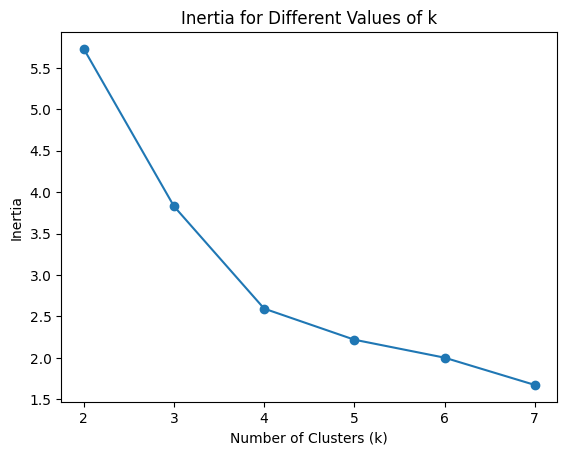

In [56]:
# Inertia (cluster compactness)
# Lower inertia indicates better compactness within clusters but does not necessarily mean 
# the best number of clusters (overfitting is possible). Optimal k may be in an elbow point. 

plt.plot(k_values, inertia_values, marker='o')
#plt.ylim(-1, 1)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Inertia for Different Values of k")
plt.show()


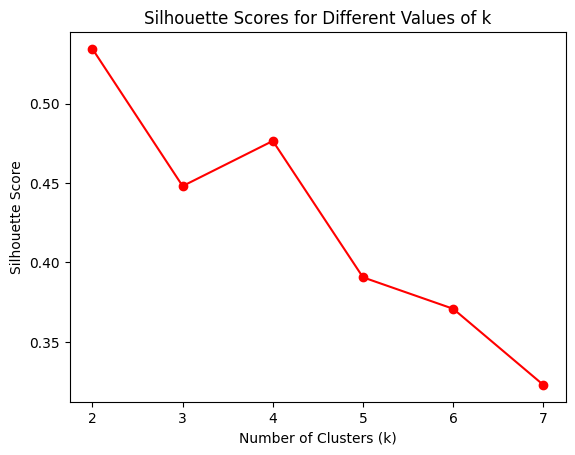

In [53]:
# Silhouette score (cluster separation)
# The score ranges from -1 to 1. A higher score indicates better-defined clusters.

plt.plot(k_values, silhouette_scores, marker='o', color='red')
#plt.ylim(0, 1)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different Values of k")
plt.show()

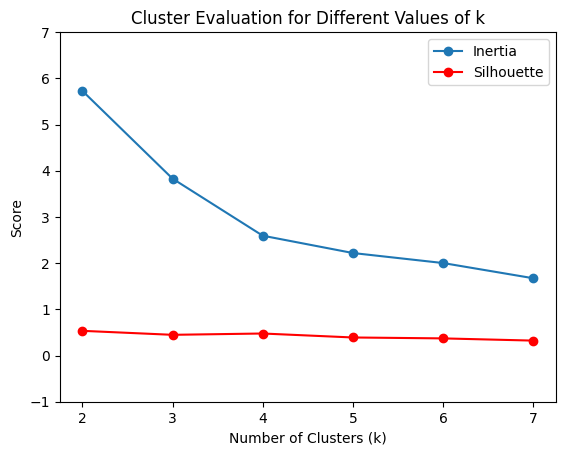

In [55]:
# Plot together
plt.plot(k_values, inertia_values, marker='o', label='Inertia')
plt.plot(k_values, silhouette_scores, marker='o', color='red', label='Silhouette')

plt.ylim(-1, 7)
plt.xticks(range(min(k_values), max(k_values) + 1, 1))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.title("Cluster Evaluation for Different Values of k")
plt.legend()
plt.show()

In [26]:
# Check out cluster stats
print(huts['cluster_kmeans_k4'].value_counts())
cluster_stats["k4"]

cluster_kmeans_k4
1    11
2     9
0     7
3     6
Name: count, dtype: int64


elevation                                        \
                          mean         std          min          max   
cluster_kmeans_k4                                                      
0                  1578.720703  666.236145   594.101807  2481.858887   
1                  2404.300537  435.917694  1917.869995  3523.820068   
2                  2086.466553  498.645020  1060.951050  2867.372070   
3                  2340.239990  201.328461  1998.727051  2574.094971   

                       slope             CR_WA_01 hydrogeo_comp  
                        mean        std      mean          mean  
cluster_kmeans_k4                                                
0                  32.525326  10.426784  3.571429           1.0  
1                  24.288061  10.197025  2.090909           2.0  
2                   6.342356   2.851967  2.888889           1.0  
3                  20.384129  12.025316  0.833333           1.0

In [35]:
# List huts for a specific cluster
huts.loc[huts['cluster_kmeans_k4'] == 1]

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,aerialway,aerialways,geometry,elevation,slope,CR_WA_01,hydrogeo_comp,cluster_kmeans_k3,cluster_kmeans_k4,cluster_kmeans_k5,cluster_kmeans_k6,cluster_kmeans_k7,cluster_dbscan
6,carèaltodongari,"CARE' ALTO ""DANTE ONGARI""",D,Alp,74,2450,0.0,goods,POINT (625663.479 5107292.054),2431.916016,25.265144,2,2,1,1,1,5,5,-1
8,cevedaleglarcher,"CEVEDALE ""GUIDO LARCHER""",D,Alp,88,2607,0.0,None,POINT (627983.759 5143939.751),2601.485107,44.052845,2,2,1,1,4,5,5,2
10,cimadastaobrentari,"CIMA D'ASTA ""OTTONE BRENTARI""",D,Alp,57,2481,0.0,goods,POINT (701043.977 5116266.942),2452.812988,22.207546,2,2,1,1,1,5,5,-1
14,mandroncittàditrento,"MANDRON ""CITTA' DI TRENTO""",D,Alp,89,2445,0.0,both,POINT (621213.949 5117752.751),2452.431885,32.730473,2,2,1,1,1,5,5,-1
16,monzonittaramelli,"MONZONI ""TORQUATO TARAMELLI""",C,Alp,16,2043,0.0,None,POINT (710684.696 5141542.381),2015.647949,29.692101,2,2,1,1,1,5,5,-1
21,saentsdorigoni,"SAENT ""SILVIO DORIGONI""",D,Alp,80,2436,0.0,None,POINT (634522.416 5146722.339),2435.016113,7.331522,2,2,1,1,1,1,1,-1
22,setteselle,SETTE SELLE,D,Alp,25,1977,0.0,None,POINT (684795.802 5111537.366),1957.676025,17.280624,3,2,1,1,1,1,1,-1
23,stavelfdenza,"STAVEL ""FRANCESCO DENZA""",D,Alp,80,2298,0.0,goods,POINT (627603.000 5122421.000),2288.843994,18.112942,3,2,1,1,1,1,1,-1
28,valdamolagsegantini,"VAL D'AMOLA ""GIOVANNI SEGANTINI""",D,Alp,54,2371,0.0,goods,POINT (631971.611 5118718.043),2369.787109,13.282906,2,2,1,1,1,1,1,-1
29,valdifumo,VAL DI FUMO,D,Alp,56,1910,0.0,None,POINT (620805.580 5104617.179),1917.869995,26.346035,2,2,1,1,1,5,5,-1


Observations:
- cluster 0 (7 huts): lowest mean elevation (although wide range), limestone component and relying on aqueduct or springs.
- cluster 1 (11 huts): highest mean elevation, only cluster of magmatic component, the majority relies on natural water bodies (streams, lakes), 2 on springs and only one (Vioz) on fusion.
- cluster 2 (9 huts): limestone component, relying on a variety of sources (four on springs, three on water bodies, two on aqueduct) --> mixed group
- cluster 3 (6 huts): high altitudes (but <2500m) with the narrowest range (most homogeneous cluster for elevation), limestone component, all relying on fusion. --> most at risk / urgent class probably.

## Proximity clustering: DBSCAN
Unlike k-means, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) doesn't require the number of clusters to be specified beforehand and can identify outliers (noise). It is based on the concept of **core points**, which represent the centers of clusters. A point is considered a core point if it has at least `min_samples` points (including itself) within a distance of `eps`. Clusters are formed by grouping together all points that are connected (density-reachable, either direclty or via other connected points) to at least one core point; points that are not density-reachable from any other point are classified as noise or outliers.

DBSCAN proves as an efficient algorithm for **spatial clustering** to identify groups of huts that are close-by based on their coordinated and elevation. 

In [27]:
# Extract coordinates as np array
coords = np.array(list(huts.geometry.apply(lambda geom: (geom.x, geom.y))))
# combine other features
features = np.hstack([coords, huts[['elevation']].values])

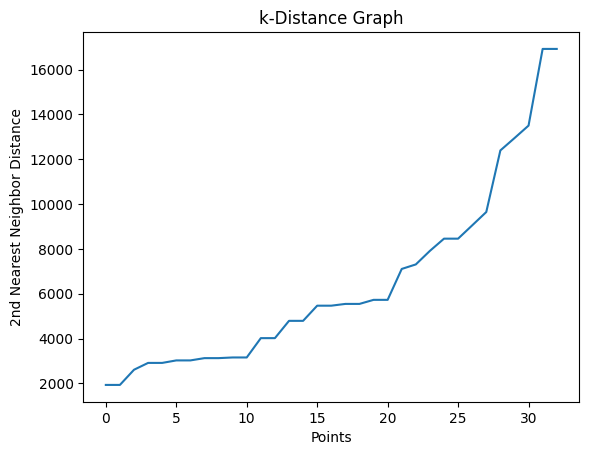

In [28]:
# Tune eps parameter with a k-distance graph: the distance from a point to its k-th nearest neighbor, look for elbow
# Fit Nearest Neighbors
neigh = NearestNeighbors(n_neighbors=2)  # min_samples-1
neigh.fit(coords)
distances, _ = neigh.kneighbors(coords)

# Sort and plot distances
distances = np.sort(distances[:, -1])  # Last column is the k-th neighbor distance
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("2nd Nearest Neighbor Distance")
plt.title("k-Distance Graph")
plt.show()


In [29]:
# DBSCAN parameters
eps = 5000  # Distance threshold in meters (adjust as needed)
min_samples = 2  # Minimum number of huts to form a cluster

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
huts['cluster_dbscan'] = dbscan.fit_predict(features).astype(str)

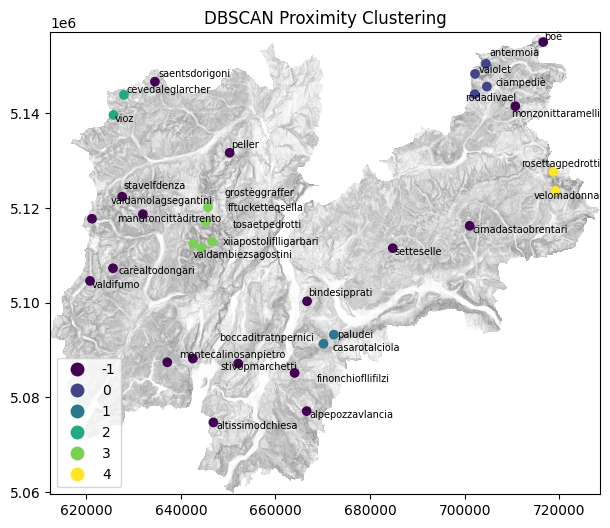

In [30]:
## Plot clusters
fig, ax = plt.subplots(figsize=(8, 6))
show(slope_raster, ax=ax, cmap='binary', alpha=0.6)
huts.plot(column='cluster_dbscan', cmap='viridis', legend=True, ax=ax)

texts = []
for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
    texts.append(ax.text(x, y, name, fontsize=7))
adjust_text(texts, ax=ax)

plt.title("DBSCAN Proximity Clustering")
plt.show()

The proximity clusters were produced with eps=5000 (meters) and min_samples=2 to identify possible 'support networks' of close-by huts. I allow small clusters of 2 huts since they are sparse. The results show 5 groups of close huts (considering position and elevation), this should be further investigated by plotting a DEM or slope map underneath. 

In [34]:
clustering_results = huts[['standard_name', 'nome_strut', 'geometry', 'elevation', 'slope', 'CR_WA_01', 'hydrogeo_comp', 'cluster_kmeans_k4', 'cluster_dbscan']]
clustering_results.to_file("../results/cluster_labels.geojson", driver='GeoJSON', crs=huts.crs)

# Ranking Clustering
This section performs clustering of the huts based on the ranks obtained with MCDM analysis in code/mcdm_analysis.ipynb . The objectives are to identify patterns among ranks.

In [125]:
ranks_df = pd.read_csv("../results/rank_df.csv")
# add geometry column for plotting later
ranks_gdf = ranks_df.merge(huts[['standard_name','geometry']], on='standard_name', how='left')
ranks_gdf = gpd.GeoDataFrame(ranks_gdf, geometry='geometry', crs=huts.crs)

configurations_cols = ['TOPSIS_custom', 'PROMETHEE_II_custom', 'VIKOR_custom']#ranks_gdf.columns[1:-1] # exclude standard_name & geometry

ranks_cluster_stats = {}
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)  
    ranks_gdf[f'cluster_kmeans_k{k}'] = kmeans.fit_predict(ranks_gdf[configurations_cols])
    ranks_cluster_stats[f"k{k}"] = ranks_gdf.groupby(f'cluster_kmeans_k{k}')[configurations_cols].agg(['mean', 'median', 'std', 'min', 'max'])


PCA: it helps to visualize how well the clusters are separated in the high-dimensional space of your rankings (with many features). The distance between points in the plot reflects how similar or different the data points (huts) are in the feature space. If the clusters are well-separated in the PCA plot, it suggests that the clustering has captured meaningful groupings in the data.



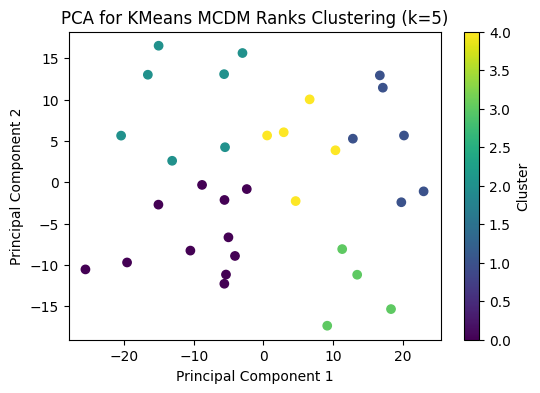

In [112]:
# Visualize clustering using PCA for dimensionality reduction (since we have many features)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(ranks_gdf[configurations_cols])

k = 5
# Plot clusters in 2D (first two principal components)
plt.figure(figsize=(6, 4))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=ranks_gdf[f'cluster_kmeans_k{k}'], cmap='viridis')
plt.title(f'PCA for KMeans MCDM Ranks Clustering (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

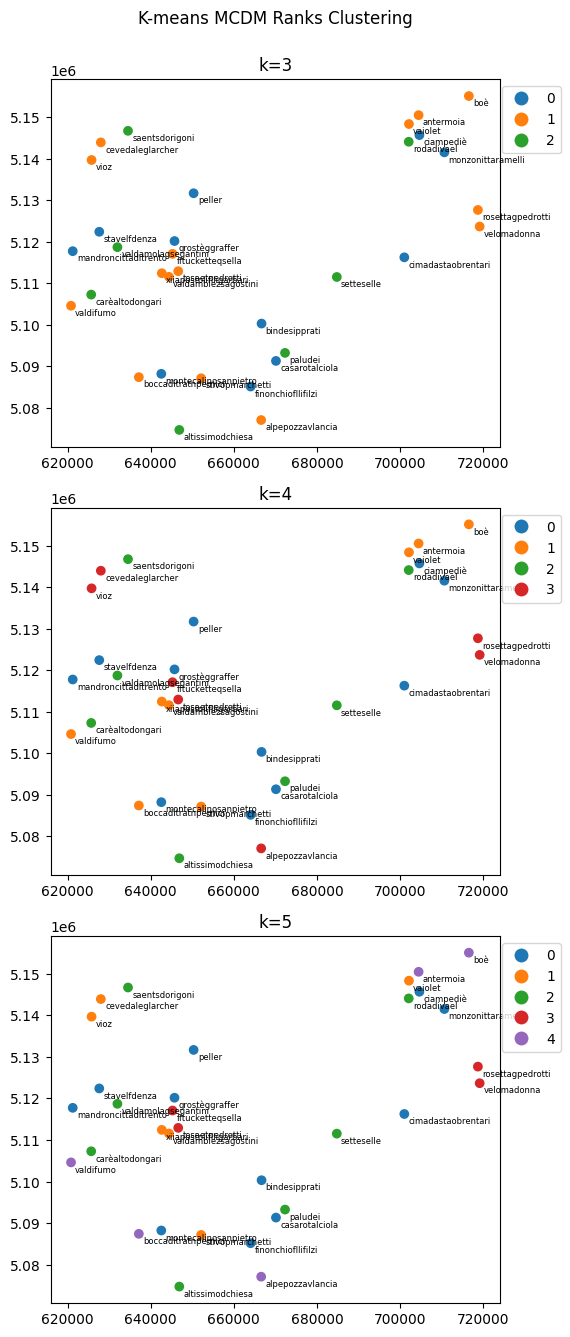

In [102]:
# Plot clusters on map
cluster_cols = [col for col in ranks_gdf.columns if 'cluster_kmeans_k' in col ]
plot_kmeans_geo(ranks_gdf, cluster_cols, "MCDM Ranks")

## Clusters interpretation

In [109]:
ranks_cluster_stats["k3"]

TOPSIS_custom                          PROMETHEE_II_custom  \
                           mean median       std min max                mean   
cluster_kmeans_k3                                                              
0                     11.272727   11.0  5.640761   1  20            8.272727   
1                     25.666667   26.0  5.094348  15  33           19.933333   
2                      7.285714    5.0  5.468525   2  17           24.428571   

                                           VIKOR_custom                       \
                  median       std min max         mean median       std min   
cluster_kmeans_k3                                                              
0                    8.0  4.713617   1  15    11.272727   11.0  6.388911   1   
1                   22.0  9.269510   2  33    25.400000   26.0  5.666947  12   
2                   26.0  5.968170  17  31     7.857143    8.0  4.740906   2   

                       
                  max  
cluster_kmeans_k3      
0                  20  
1                  33  
2                  14

- Cluster 0 (Moderate Performance): Huts perform well overall, with PROMETHEE_II_custom favoring them the most (lowest range, mean and std).
- Cluster 1 (Low Performance): Huts in this cluster consistently rank lower across all methods but show more variability (range and std).
- Cluster 2 (Polarized Performance): Strong performance under TOPSIS_custom and VIKOR_custom but weaker under PROMETHEE_II_custom. These huts might align with specific criteria that are valued by the first two methods but not the latter.

In [110]:
ranks_cluster_stats["k4"]

TOPSIS_custom                          PROMETHEE_II_custom  \
                           mean median       std min max                mean   
cluster_kmeans_k4                                                              
0                     11.272727   11.0  5.640761   1  20            8.272727   
1                     24.125000   24.5  4.853202  15  30           26.750000   
2                      7.285714    5.0  5.468525   2  17           24.428571   
3                     27.428571   28.0  5.126960  19  33           12.142857   

                                           VIKOR_custom                       \
                  median       std min max         mean median       std min   
cluster_kmeans_k4                                                              
0                    8.0  4.713617   1  15    11.272727   11.0  6.388911   1   
1                   26.0  4.062019  22  33    22.500000   23.5  5.580579  12   
2                   26.0  5.968170  17  31     7.857143    8.0  4.740906   2   
3                   12.0  6.962485   2  21    28.714286   29.0  3.817254  22   

                       
                  max  
cluster_kmeans_k4      
0                  20  
1                  30  
2                  14  
3                  33

In [111]:
ranks_cluster_stats["k5"]

TOPSIS_custom                          PROMETHEE_II_custom  \
                           mean median       std min max                mean   
cluster_kmeans_k5                                                              
0                     11.272727   11.0  5.640761   1  20            8.272727   
1                     29.166667   29.5  2.857738  25  33           26.166667   
2                      7.285714    5.0  5.468525   2  17           24.428571   
3                     27.250000   27.0  3.774917  23  32            7.250000   
4                     20.200000   21.0  3.420526  15  24           22.600000   

                                           VIKOR_custom                       \
                  median       std min max         mean median       std min   
cluster_kmeans_k5                                                              
0                    8.0  4.713617   1  15    11.272727   11.0  6.388911   1   
1                   26.0  5.671567  19  33    28.333333   28.5  3.559026  24   
2                   26.0  5.968170  17  31     7.857143    8.0  4.740906   2   
3                    7.5  4.272002   2  12    28.750000   28.5  2.500000  26   
4                   23.0  4.335897  16  28    19.200000   21.0  4.438468  12   

                       
                  max  
cluster_kmeans_k5      
0                  20  
1                  33  
2                  14  
3                  32  
4                  23

- Cluster 0 (Moderately Good): Stable from k=3, consistently includes huts with decent rankings across methods.
- Cluster 1 (Lowest Performance): Poorest-ranked huts, with little variability and no strong alignment with any method.
- Cluster 2 (Top Performers): Huts that excel under TOPSIS_custom and VIKOR_custom but are penalized by PROMETHEE_II_custom.
- Cluster 3 (Divergent Performance): Sharp divergence in performance, being highly favored by PROMETHEE_II_custom but poor under other methods.
- Cluster 4 (Moderately Low): Huts with middling-to-low rankings across methods, less extreme than Cluster 1.

### Cluster profiles
What are the characteristics (criteria-based) of the huts in each cluster? 
e.g. Cluster 0: reliable water source, aerialway, generator.

In [122]:
criteria_gdf = gpd.read_parquet("../data/alternatives_qnt.parquet")

# Merge the cluster labels into criteria_gdf
merge_cols = [col for col in ranks_gdf.columns if 'cluster_kmeans_k' in col]
merge_cols.append('standard_name')
criteria_gdf = criteria_gdf.merge(ranks_gdf[merge_cols], on='standard_name')

cluster_criteria_stats = {}
for col in merge_cols[:-1]:
    k = col[-1]
    # Compute summary statistics for each criterion by cluster
    cluster_criteria_stats[f"k{k}"] = criteria_gdf.groupby(f'cluster_kmeans_k{k}').agg({
        'CR_WA_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_WA_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_03': ['mean', 'median', 'std', 'min', 'max'],
        'CR_EN_04': ['mean', 'median', 'std', 'min', 'max'],
        'CR_SU_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_SU_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_AC_01': ['mean', 'median', 'std', 'min', 'max'],
        'CR_AC_02': ['mean', 'median', 'std', 'min', 'max'],
        'CR_AC_03': ['mean', 'median', 'std', 'min', 'max']
    })


In [123]:
cluster_criteria_stats["k5"]

CR_WA_01                            CR_WA_02         \
                       mean median       std min max       mean median   
cluster_kmeans_k5                                                        
0                  3.090909    3.0  0.831209   2   4  78.181818    0.0   
1                  1.166667    1.0  0.752773   0   2  36.666667   30.0   
2                  2.857143    3.0  0.899735   2   4  10.428571    2.0   
3                  1.500000    1.0  1.000000   1   3  42.500000   40.0   
4                  2.400000    2.0  0.547723   2   3  36.000000   20.0   

                                            ...  CR_AC_02                   \
                          std   min    max  ...      mean median       std   
cluster_kmeans_k5                           ...                              
0                  239.617119   0.0  800.0  ...  1.636364    1.0  0.809040   
1                   28.047579  10.0   80.0  ...  1.166667    1.0  0.408248   
2                   12.959644   0.0   30.0  ...  1.285714    1.0  0.487950   
3                   37.749172   0.0   90.0  ...  1.250000    1.0  0.500000   
4                   38.236109   2.0  100.0  ...  1.200000    1.0  0.447214   

                           CR_AC_03                           
                  min max      mean median       std min max  
cluster_kmeans_k5                                             
0                   1   3  2.818182    3.0  1.078720   1   4  
1                   1   2  3.833333    4.0  0.752773   3   5  
2                   1   2  3.285714    4.0  1.112697   1   4  
3                   1   2  3.750000    4.0  0.500000   3   4  
4                   1   2  3.600000    4.0  0.547723   3   4  

[5 rows x 55 columns]

In [128]:
criteria_gdf_nonames = criteria_gdf.drop(columns='standard_name')
cluster_stats = criteria_gdf_nonames.groupby('cluster_kmeans_k5').mean()

# Reset index to make 'cluster_kmeans_k5' a column
cluster_stats.reset_index(inplace=True)

# Rename columns to include "_mean" suffix for clarity
cluster_stats.rename(columns=lambda x: f"{x}_mean" if x != 'cluster_kmeans_k5' else x, inplace=True)

# Convert to dictionary format for plotting
data = cluster_stats.to_dict(orient='list')

# Example output for verification
print(data)

TypeError: agg function failed [how->mean,dtype->geometry]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace this with your actual grouped stats)
data = {
    "cluster_kmeans_k5": [0, 1, 2, 3, 4],
    "CR_WA_01_mean": [3.090909, 1.166667, 2.857143, 1.5, 2.4],
    "CR_WA_02_mean": [78.181818, 36.666667, 10.428571, 42.5, 36],
    "CR_AC_02_mean": [1.636364, 1.166667, 1.285714, 1.25, 1.2],
    "CR_AC_03_mean": [2.818182, 3.833333, 3.285714, 3.75, 3.6]
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Drop the cluster column for normalization
clusters = df["cluster_kmeans_k5"]
df_values = df.drop(columns=["cluster_kmeans_k5"])

# Min-max normalization
normalized_df = (df_values - df_values.min()) / (df_values.max() - df_values.min())
normalized_df["cluster_kmeans_k5"] = clusters

# Reshape to long format for plotting
melted = normalized_df.melt(
    id_vars="cluster_kmeans_k5",
    var_name="Criterion",
    value_name="Normalized Value"
)

# Create the bar chart
plt.figure(figsize=(14, 8))
sns.barplot(
    data=melted,
    x="Criterion",
    y="Normalized Value",
    hue="cluster_kmeans_k5",
    palette="viridis"
)

plt.title("Normalized Criterion Values by Cluster (k=5)")
plt.xlabel("Criterion")
plt.ylabel("Normalized Value")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()
